# Análisis exploratorio de datos

El conjunto de datos con el que trabajaremos es una recopilación de situaciones de ajedrez en las cuales el rey y la torre blanca intentan dar mate al rey negro en un determinado número de jugadas. METER LINK

El objetivo es determinar, a partir de las posiciones del rey y la torre negra, el número de movimientos necesario para dar mate al rey negro. Es posible que la configuración de piezas no dé lugar a un mate y acabe en tablas. Además, todos los datos están generados asumiendo un estilo de juego óptimo usando el estimador de teoría de juegos _Minimax_

Nuestro conjunto de datos está formado por 7 columnas, de las cuales las 6 primeras serán las variables predictoras y la última la variable a predecir:

1. Columna del rey blanco (wkc)
2. Fila del rey blanco (wkr)
3. Columna de la torre blanca (wrc)
4. Fila de la torre blanca (wrr)
5. Columna del rey negro (bkc)
6. Fila del rey negor (bkr)
7. Número de movimientos óptimos para que ganen las blancas. Varían del 0 al 16 más la posibilidad de empate.

Nuestro trabajo será construir modelos que sean capaces de predecir el número de movimientos óptimos para ganar a partir de las posiciones de las tres piezas.



In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

Importamos los datos usando pandas:

In [12]:
data = pd.read_csv("krkopt.data", header=None)
data.columns = ["wkc", "wkr", "wrc", "wrr", "bkc", "bkr", "opt rank" ]

Veamos la estructura del conjunto:

In [13]:
data

,wkc,wkr,wrc,wrr,bkc,bkr,opt rank
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw
...,...,...,...,...,...,...,...
28051,b,1,g,7,e,5,sixteen
28052,b,1,g,7,e,6,sixteen
28053,b,1,g,7,e,7,sixteen
28054,b,1,g,7,f,5,sixteen


Existe un total de 28056 casos para 7 columnas. 

Comprobamos si existen valores perdidos:

In [14]:
np.sum(data.isnull())

wkc         0
wkr         0
wrc         0
wrr         0
bkc         0
bkr         0
opt rank    0
dtype: int64

No existen valores omitidos, por lo que podemos usar todos los casos sin ningún problema.

Estamos interesados en predecir los valores de _otp rank_, nos preguntamos cuál es la distribución de los casos para esta columna:

<AxesSubplot:xlabel='opt rank', ylabel='count'>

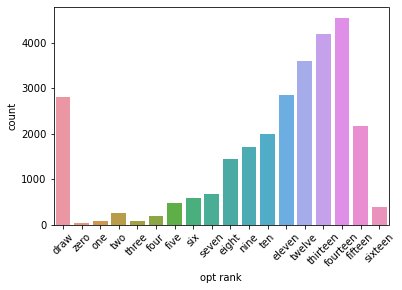

In [15]:
plt.xticks(rotation=45)
sns.countplot(x='opt rank',
             data=data)

In [16]:
from collections import Counter
counter = Counter(data['opt rank'])
for k,v in counter.items():
	per = v / len(data['opt rank']) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))

Class=draw, n=2796 (9.966%)
Class=zero, n=27 (0.096%)
Class=one, n=78 (0.278%)
Class=two, n=246 (0.877%)
Class=three, n=81 (0.289%)
Class=four, n=198 (0.706%)
Class=five, n=471 (1.679%)
Class=six, n=592 (2.110%)
Class=seven, n=683 (2.434%)
Class=eight, n=1433 (5.108%)
Class=nine, n=1712 (6.102%)
Class=ten, n=1985 (7.075%)
Class=eleven, n=2854 (10.173%)
Class=twelve, n=3597 (12.821%)
Class=thirteen, n=4194 (14.949%)
Class=fourteen, n=4553 (16.228%)
Class=fifteen, n=2166 (7.720%)
Class=sixteen, n=390 (1.390%)


Tal y como vemos, se trata de un problema de clasificación desbalanceada. Existe una gran tendencia en la distribución a necesitar un número de entre diez y catorce pasos para acabar la partida. Destacamos, de igual manera, la importante cantidad de veces que acaba en tablas. Hay muy poca representanción de partidas que puedan acabar en el rango de uno a siete movimientos.

Este tipo de conjuntos de datos son problemáticos ya que el gran desbalanceo existente entre las clases impide que los modelos construidos consigan buenas métricas en la clasificación. Por ello, usaremo, además de los datos _raw_, la herramiento SMOTE, que realiza un sobremuestreo de los datos. Su funcionamiento es parecido a la interpolación, pero mucho más complejo.

Continuamos con la distribución de las demás clases en cada variable predictora:

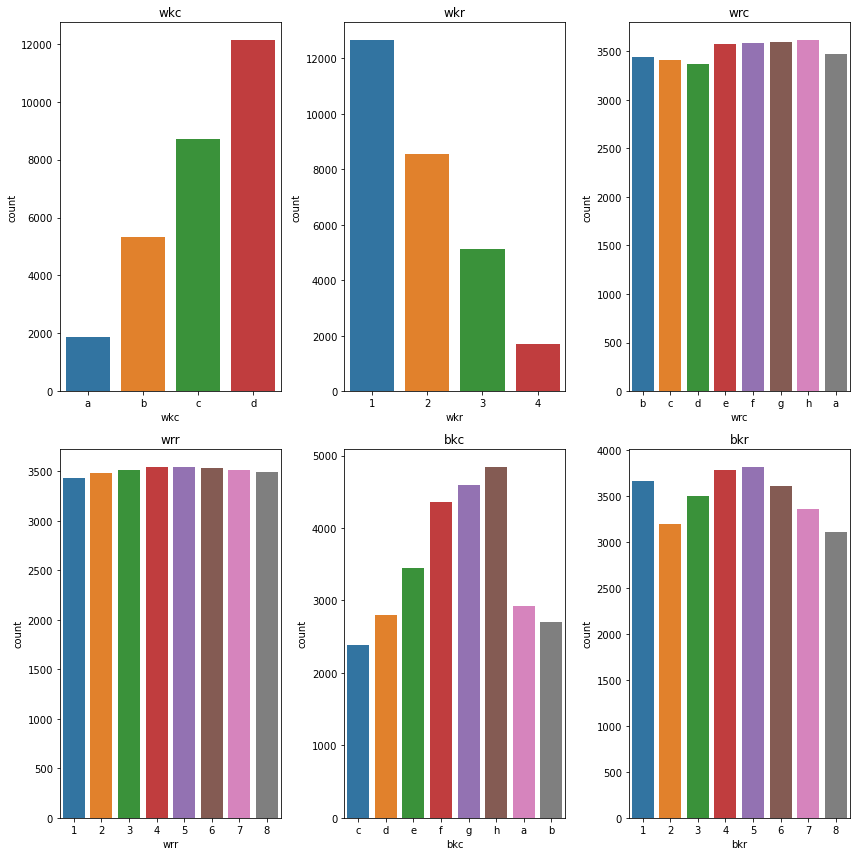

In [18]:
f, ax = plt.subplots(2,3, figsize=(12,12) )
sns.countplot(ax= ax[0,0], x='wkc',
             data=data)
sns.countplot(ax= ax[0,1], x='wkr',
             data=data)
sns.countplot(ax= ax[0,2], x='wrc',
             data=data)
sns.countplot(ax= ax[1,0], x='wrr',
             data=data)
sns.countplot(ax= ax[1,1], x='bkc',
             data=data)
sns.countplot(ax= ax[1,2], x='bkr',
             data=data)


ax[0,0].set_title("wkc")
ax[0,1].set_title("wkr")
ax[0,2].set_title("wrc")
ax[1,0].set_title("wrr")
ax[1,1].set_title("bkc")
ax[1,2].set_title("bkr")

plt.tight_layout()
plt.savefig('foo.pdf', transparent=True)

Existe una mayor homogeneidad en las variables predictoras correspondientes a la posición de las torres. 

Es curioso que el rey blanco suele estar en la columna d en la primera fila, mientras que el rey negro presenta una distribución mucho más variada.

Todavía no hemos realizado ningúna conversión de los tipos ya que preferimos aplazarlo hasta la aplicación de determinados algoritmos, que nos exijan la codificación de las columnas en un deterimnado tipo.

## Importancia de variables

Podemos utilizar algoritmos basados en árboles de decisión como RandomForest para estimar qué variables predictoras importan más a la hora de determinar la variable a predecir.

Para ello utilizaremos el paquete Scikit-learn. En primer lugar codificaremos numéricamente las variables categóricas.

In [19]:
data_aux = data.copy()
data_aux[['wkc', 'wrc', 'bkc']] = data_aux[['wkc', 'wrc', 'bkc']].astype('category')

data_aux['wkc'] = data_aux['wkc'].cat.codes
data_aux['wrc'] = data_aux['wrc'].cat.codes
data_aux['bkc'] = data_aux['bkc'].cat.codes

Entrenamos un modelo de RandomForest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_aux.drop("opt rank", axis=1), data_aux['opt rank']
                                                    ,test_size=0.2)
feature_names = [f'feature {i}' for i in range(data_aux.drop('opt rank', axis=1).shape[1])]

forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

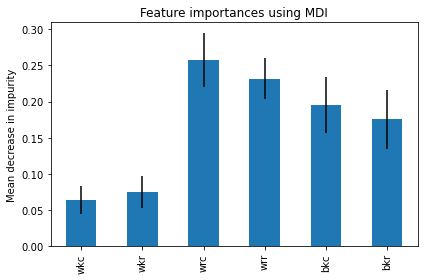

In [22]:
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticks([0,1,2,3,4,5]) # values
labels = list(data_aux.columns[:-1])
ax.set_xticklabels(labels) # labels
positions = (1, 2, 3,4, 5)


fig.tight_layout()

Las variables más importantes a la hora de determinar el número de pasos son las coordenadas de la torre junto a las coordenadas del rey negro. Parece que la posición del rey blanco no es tan importante como el papel de la torre a la hora de ir _acorralando_ al rey negro.

Podemos dar por finalizado el análisis exploratorio de datos, ya que no necesitamos hacer ningún test estadístico o análisis continuo de los datos debido a la naturaleza categórica de los mismos. Además, la distribución de clases por columna no sigue ninguna distribución normal, atendiendo a las figuras obtenidas.

# Creación de modelos con redes neuronales con TensorFlow

De acuerdo a lo aprendido en la asignatura, utilizaremos TensorFlow en su versión 2.5 para crear distintos modelos de redes neuronales para abordar este problema de clasificación. Los datos que usaremos son los originales y los balanceados usando SMOTE. 

Para cada conjunto crearemos distintos modelos de perceptrón multicapa en los cuales variaremos la profundidad del mismo (número de capas) así como la cantidad de neuronas por capa. 

Haremos uso de técnicas como dropout y callbacks. La técnica del dropout consiste en desactivar ciertas neuronas por capa de forma aleatoria en cada época con el fin de evitar que la red neuronal sobreaprenda. Con esta idea, se debe poder conseguir redes neuronales de mayor tamaño que permitan aprender más características del conjunto de datos aún sin sobreaprender. 

Los callbacks son utilidades que incluye Tensorflow que facilitan el entrenamiento de los modelos. Podemos guardar en disco el modelo que mejor resultado da en función de una métrica de control. En nuestro caso, estamos interesados en la función _EarlyStopping_ que permite acabar el entrenamiento de forma automática si, tras un número determinado a elegir de épocas, la métrica que elijamos no ha mejorado. Esta ventaja es fundamental ya que nos ahorra tener que incluir el número de épocas dentro de los parámetros tuneables durante el entrenamiento.

Para realizar el entrenamiento, estamos usando Linux junto a una tarjeta gráfica Nvidia 1070 max-q que nos ayuda a acelerar el trabajo de forma drástica. El entorno de Linux permite la configuración de las librerías CUDA de forma sencilla.

De entre los modelos vistos en clase, nos hemos decantado por el perceptrón multicapa ya que es el que más fácilmente se adapta a este problema. Por un lado, no podemos usar las redes convolucionales, joya de la corona del deep learning actualmente, ya que se usan en reconomiento de imágenes. No sabemos cómo utilizar las capas convolucionales en este tipo de datos. Muchas funcionalidades de TensorFlow no son usadas, como _DataAugmentation_, que permite variar el conjunto de entrenamiento para que la red neuronal tenga más variedad durante el mismo. Por otro lado, los mapas autogenerativos así como las redes neuronales con funciones de base radial no tienen suficiente documentación en internet para este tipo de problemas. Las redes neuronales recurrentes no se suelen usar en estas situaciones.

# Creación de árboles de clasificación con TensorFlowDecisionTrees

Con el fin de investigar más y aprendiendo sobre TensorFlow, descubrimos que, recientemente (Mayo de 2021), se ha incluido en la librería una API en la que se  implementan de tres algoritmos muy famosos de árboles de decisión: Random Forest, Gradient Boosted Trees y CART.

Estos algoritmos, los cuales hemos visto en el máster, se ejecutan en C++ con la librería, también de Google, Yggdrasil Decision Forests. En realidad, al igual que la API en Python de TensorFlow, estamos utilizando un wrapper en el cual creamos los modelos fácilmente en Python que posteriormente serán entrenados en C++. De momento, esta librería no hace uso de la tarjeta gráfica.

La API se llama TensorFlow Decision Forest y puede ser instalada con `pip3 install tensorflow_decision_forests --upgrade`. 

